# Dogs vs. Cats

# 一、数据预处理

##  1、定义函数

In [1]:
# -*- coding=UTF-8 -*-
import os
import shutil
from tqdm import tqdm
from urllib.request import urlretrieve

IF_MKDIR = 0   # 创建的文件夹是否覆盖原来的

def rmdir_mkdir(dirname):
    '''创建文件夹，若存在删除，重新创建
    
    Args:
        dirname:文件夹名
        
    Returns:
        None
    '''
    if os.path.exists(dirname) and IF_MKDIR:
        shutil.rmtree(dirname) # 若存在则删除该文件夹（包括里面的内容
    if IF_MKDIR:
        os.mkdir(dirname)


class DLProgress(tqdm):  
    '''进度条类，继承自tqdm
    '''
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

## 2、下载数据、解压数据包

In [2]:
import zipfile

if not os.path.isfile('train.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Andimal Dataset') as pbar:
        urlretrieve('https://www.kaggle.com/c/dogs-vs-cats/download/train.zip',
                    'train.zip',
                    pbar.hook)
if not os.path.isfile('train.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Andimal Dataset') as pbar:
        urlretrieve('https://www.kaggle.com/c/dogs-vs-cats/download/test1.zip',
                    'test1.zip',
                    pbar.hook)

if not os.path.isdir("train"):
    with zipfile.ZipFile('train.zip') as zipp:
        zipp.extractall()
        zipp.close()
        
if not os.path.isdir("test1"):
    with zipfile.ZipFile('test1.zip') as zipp:
        zipp.extractall()
        zipp.close()

## 3、导入Keras包

In [3]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger,  History, ModelCheckpoint, EarlyStopping

d:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 4、图像载入、尺寸变换

In [4]:
import numpy as np
from tqdm import tqdm
import cv2

np.random.seed(42)

class Pictures(object):
    def __init__(self,n=25000):
        """构造函数
        # Arguments
            n: 图像数量
        # Return
            None
        """
        self.pic_num = n
        self.shape = None
        self.X = None
        self.y = None

    def resize(self, shape=(224,224)):
        """图像归一化
        
            img = Pictures()
            img.resize()
        # Arguments
            shape: 规划化后图像尺寸
        # Return
            None
        """
        self.shape = shape
        self.X = np.zeros((self.pic_num, self.shape[0], self.shape[1], 3), dtype=np.uint8)
        self.y = np.zeros((self.pic_num, 1), dtype=np.uint8)
        for i in tqdm(range(int(self.pic_num/2))):
            self.X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg' %i), (self.shape[0], self.shape[1]))
            self.X[i+int(self.pic_num/2)] = cv2.resize(cv2.imread('train/dog.%d.jpg' %i), (self.shape[0], self.shape[1]))
        self.y[int(self.pic_num/2):] = 1                

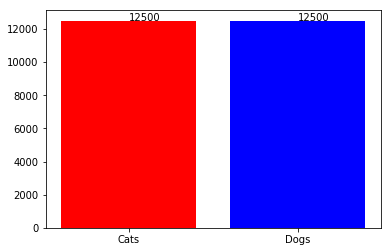

In [7]:
# 绘制图形
import matplotlib.pyplot as plt
aninal_num = [12500,12500]
plt.bar([0,1],
        aninal_num,
        color=['r','b'],
        tick_label =['Cats','Dogs'],
        label = ['12500','12500'])
# plt.xticks([0,1],('Cats','Dogs'))
plt.text(0,12500,"12500")
plt.text(1,12500,"12500")
plt.show()

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

img_224 = Pictures()
img_224.resize(shape=(224,224))

img_299 = Pictures()
img_299.resize(shape=(299,299))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:25<00:00, 147.03it/s]


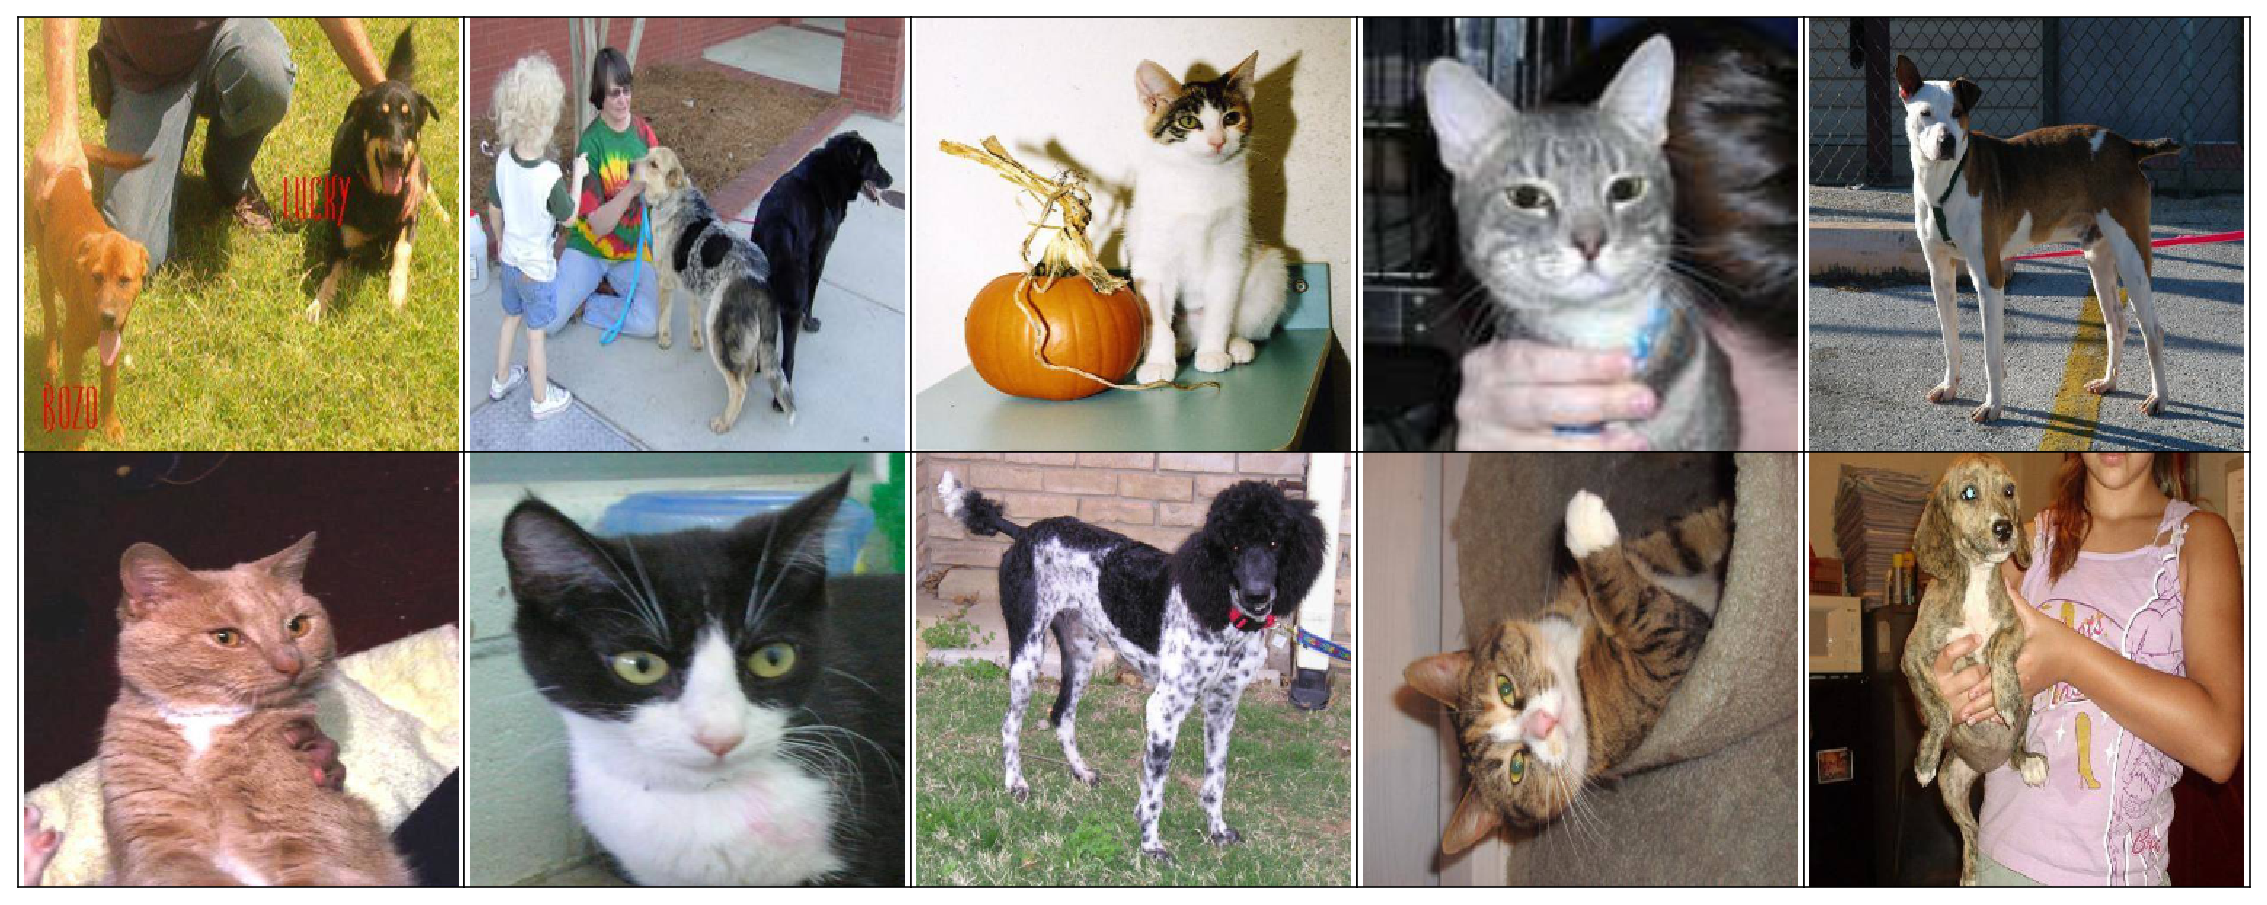

In [9]:
# OpenCV版本
idx = np.random.randint(0,img_299.X.shape[0],size = 10)
fig, axes = plt.subplots(2,5,sharex=True ,sharey=True ,figsize=(20,8))
for i, ax in zip(idx,axes.flatten()):
    ax.imshow(img_299.X[i][:,:,::-1],aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0,hspace=0)

## 5、将数据分为训练集、验证集

In [10]:
from sklearn.model_selection import train_test_split
X_train_224, X_valid_224, y_train_224, y_valid_224 = train_test_split(img_224.X, img_224.y, test_size=0.2)

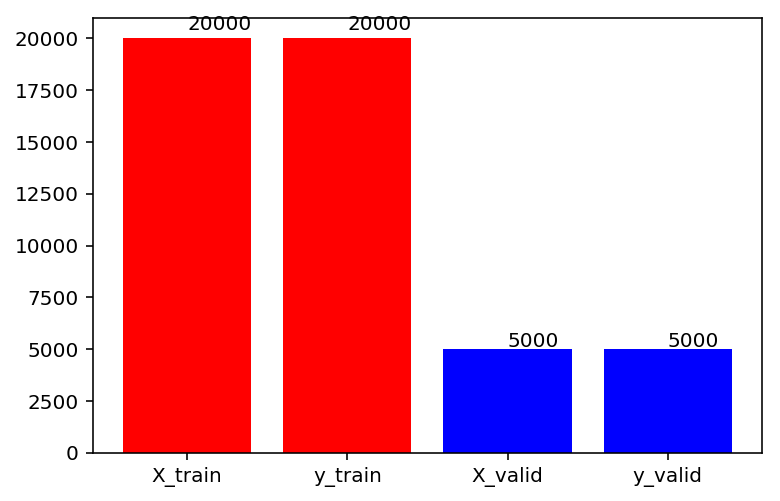

In [11]:
# 绘制图形
import matplotlib.pyplot as plt
%matplotlib inline

aninal_num = [len(X_train_224),len(y_train_224),len(X_valid_224),len(y_valid_224)]
plt.bar([0,1,2,3],
        aninal_num,
        align='center',
        color=['r','r','b','b'],
        tick_label =['X_train','y_train','X_valid','y_valid'],
        label = [str(len(X_train_224)),str(len(y_train_224)),str(len(X_valid_224)),str(len(y_valid_224))])

plt.text(0,len(X_train_224)*1.02,str(len(X_train_224)))
plt.text(1,len(y_train_224)*1.02,str(len(y_train_224)))
plt.text(2,len(X_valid_224)*1.02,str(len(X_valid_224)))
plt.text(3,len(y_valid_224)*1.02,str(len(y_valid_224)))
plt.show()

# 二、使用Keras预训练模型测试

## 1、VGG19

In [11]:
from keras.applications.vgg19 import VGG19, preprocess_input as vgg19_preprocess_input
base_model = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False) # 调用VGG预训练模型
for layers in base_model.layers:
    layers.trainable = False

x = Input((224, 224, 3))
in_tensor = Lambda(vgg19_preprocess_input)(x)
y = base_model(in_tensor)

y = GlobalAveragePooling2D()(y) 
y = Dropout(0.25)(y)
y = Dense(1, activation='sigmoid')(y)
model_VGG19 = Model(x, y)

In [12]:
model_VGG19.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
train_history_VGG19 = model_VGG19.fit(X_train_224, y_train_224, batch_size=16, epochs=10, verbose=2, 
                                      validation_data=(X_valid_224, y_valid_224))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 224s - loss: 0.4045 - acc: 0.8917 - val_loss: 0.1073 - val_acc: 0.9678
Epoch 2/10
 - 203s - loss: 0.1488 - acc: 0.9552 - val_loss: 0.0988 - val_acc: 0.9714
Epoch 3/10
 - 203s - loss: 0.1123 - acc: 0.9647 - val_loss: 0.0942 - val_acc: 0.9726
Epoch 4/10
 - 203s - loss: 0.1034 - acc: 0.9680 - val_loss: 0.0880 - val_acc: 0.9756
Epoch 5/10
 - 203s - loss: 0.0989 - acc: 0.9683 - val_loss: 0.0851 - val_acc: 0.9744
Epoch 6/10
 - 203s - loss: 0.0863 - acc: 0.9721 - val_loss: 0.0857 - val_acc: 0.9752
Epoch 7/10
 - 203s - loss: 0.0862 - acc: 0.9730 - val_loss: 0.0811 - val_acc: 0.9752
Epoch 8/10
 - 203s - loss: 0.0779 - acc: 0.9744 - val_loss: 0.0792 - val_acc: 0.9764
Epoch 9/10
 - 203s - loss: 0.0750 - acc: 0.9735 - val_loss: 0.0782 - val_acc: 0.9772
Epoch 10/10
 - 203s - loss: 0.0721 - acc: 0.9746 - val_loss: 0.0779 - val_acc: 0.9760


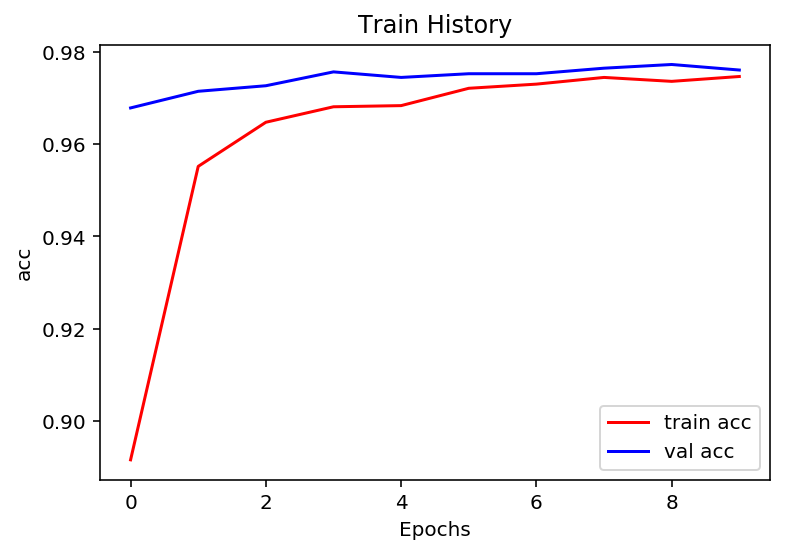

In [13]:
from utils import *
%matplotlib inline
show_train_history(train_history_VGG19, "acc", "val_acc")

In [14]:
# 保存模型

# 将模型保存为 JSON
model_json_VGG19 = model_VGG19.to_json()
with open("model_VGG19.json", "w") as json_file:
    json_file.write(model_json_VGG19)
# 将权重保存为 HDF5
model_VGG19.save_weights("model_VGG19.h5")
print("Saved model to Disk")

Saved model to Disk


In [12]:
# 加载预测图像
X_test_224 = np.zeros((12500, 224, 224, 3), dtype=np.uint8)
n = 25000
for i in tqdm(range(int(n/2))):
    X_test_224[i] = cv2.resize(cv2.imread('test1/%d.jpg' %(i+1)), (224, 224))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:41<00:00, 122.78it/s]


In [16]:
# 预测测试集
y_pred_VGG19 = model_VGG19.predict(X_test_224, verbose=0)
y_pred_VGG19 = y_pred_VGG19.clip(min=0.005, max=0.995)

In [17]:
import pandas as pd
import glob

df_VGG19 = pd.read_csv("sample_submission.csv")

testImageName =glob.iglob('test1/*.jpg') 

for i in range(12500):
    fname = "train1"+str(i)+".jpg"
#     value = None
#     if  y_pred_VGG19[i] > 0.5:
#         value = 1
#     else:
#         value = 0
    value = y_pred_VGG19[i]
    df_VGG19.set_value(i, 'label',value)

df_VGG19.to_csv('y_pred_VGG19.csv', index=None)
df_VGG19.head(10)

d:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

Kaggle评分

<img src="img/y_pred_VGG19.png" width=900px>

## 2、 ResNet50

In [9]:
from keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess_input
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = Input((224, 224, 3))
in_tensor = Lambda(resnet_preprocess_input)(x)   
y = base_model(in_tensor)

y = GlobalAveragePooling2D()(y)
y = Dropout(0.25)(y)
y = Dense(1, activation='sigmoid')(y)
model_ResNet50 = Model(x, y)

In [20]:
model_ResNet50.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
train_history_ResNet50 = model_ResNet50.fit(X_train_224, y_train_224, batch_size=32, epochs=10, verbose=2, 
                                            validation_data=(X_valid_224, y_valid_224))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 141s - loss: 0.1756 - acc: 0.9354 - val_loss: 0.0935 - val_acc: 0.9646
Epoch 2/10
 - 139s - loss: 0.0945 - acc: 0.9651 - val_loss: 0.0782 - val_acc: 0.9710
Epoch 3/10
 - 139s - loss: 0.0785 - acc: 0.9702 - val_loss: 0.0693 - val_acc: 0.9744
Epoch 4/10
 - 139s - loss: 0.0736 - acc: 0.9709 - val_loss: 0.0671 - val_acc: 0.9746
Epoch 5/10
 - 140s - loss: 0.0736 - acc: 0.9715 - val_loss: 0.0656 - val_acc: 0.9746
Epoch 6/10
 - 139s - loss: 0.0710 - acc: 0.9724 - val_loss: 0.0643 - val_acc: 0.9754
Epoch 7/10
 - 139s - loss: 0.0699 - acc: 0.9735 - val_loss: 0.0639 - val_acc: 0.9758
Epoch 8/10
 - 138s - loss: 0.0706 - acc: 0.9727 - val_loss: 0.0626 - val_acc: 0.9768
Epoch 9/10
 - 141s - loss: 0.0645 - acc: 0.9750 - val_loss: 0.0642 - val_acc: 0.9764
Epoch 10/10
 - 138s - loss: 0.0634 - acc: 0.9760 - val_loss: 0.0623 - val_acc: 0.9778


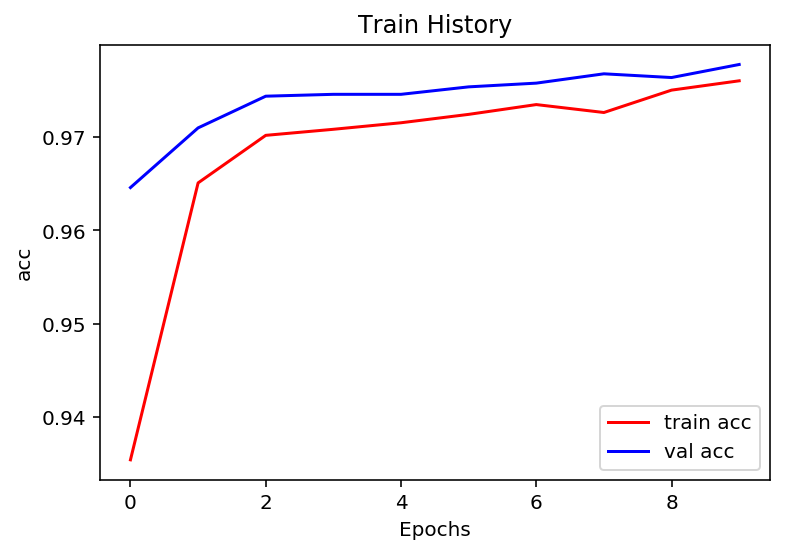

In [21]:
from utils import *
show_train_history(train_history_ResNet50, "acc", "val_acc")

In [22]:
# 保存模型

# 将模型保存为 JSON
model_json_ResNet50 = model_ResNet50.to_json()
with open("model_RetNet50.json", "w") as json_file:
    json_file.write(model_json_ResNet50)
# 将权重保存为 HDF5
model_ResNet50.save_weights("model_ResNet50.h5")
print("Saved model to Disk")

Saved model to Disk


In [23]:
# 预测测试集
y_pred_ResNet50 = model_ResNet50.predict(X_test_224, verbose=0)
y_pred_ResNet50 = y_pred_ResNet50.clip(min=0.005, max=0.995)

In [24]:
df_ResNet50 = pd.read_csv("sample_submission.csv")

testImageName =glob.iglob('test1/*.jpg') 

for i in range(12500):
    fname = "train1"+str(i)+".jpg"
#     value = None
#     if  y_pred_ResNet50[i] > 0.5:
#         value = 1
#     else:
#         value = 0
    value = y_pred_ResNet50[i]
    df_ResNet50.set_value(i, 'label',value)

df_ResNet50.to_csv('y_pred_ResNet50.csv', index=None)
df_ResNet50.head(10)

d:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

Kaggle评分

<img src="img/y_pred_ResNet50.png" width=900px>

## 3、 InceptionV3

In [25]:
X_train_299, X_valid_299, y_train_299, y_valid_299 = train_test_split(img_299.X, img_299.y, test_size=0.2)

In [26]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_v3_preprocess_input
base_model = InceptionV3(input_shape=(299, 299, 3), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = Input((299, 299, 3))
in_tensor = Lambda(inception_v3_preprocess_input)(x) 
y = base_model(in_tensor)

y = GlobalAveragePooling2D()(y)
y = Dropout(0.25)(y)
y = Dense(1, activation='sigmoid')(y)
model_InceptionV3 = Model(x, y)

In [27]:
model_InceptionV3.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
train_history_InceptionV3 = model_InceptionV3.fit(X_train_299, y_train_299, batch_size=32, epochs=10, verbose=2, 
                                                  validation_data=(X_valid_299, y_valid_299))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 263s - loss: 0.2351 - acc: 0.9263 - val_loss: 0.1136 - val_acc: 0.9764
Epoch 2/10
 - 207s - loss: 0.1282 - acc: 0.9570 - val_loss: 0.0989 - val_acc: 0.9688
Epoch 3/10
 - 198s - loss: 0.1103 - acc: 0.9605 - val_loss: 0.0748 - val_acc: 0.9788
Epoch 4/10
 - 199s - loss: 0.1033 - acc: 0.9621 - val_loss: 0.0697 - val_acc: 0.9790
Epoch 5/10
 - 214s - loss: 0.0945 - acc: 0.9644 - val_loss: 0.0653 - val_acc: 0.9810
Epoch 6/10
 - 216s - loss: 0.0978 - acc: 0.9628 - val_loss: 0.0637 - val_acc: 0.9804
Epoch 7/10
 - 216s - loss: 0.0917 - acc: 0.9658 - val_loss: 0.0612 - val_acc: 0.9800
Epoch 8/10
 - 217s - loss: 0.0896 - acc: 0.9653 - val_loss: 0.0595 - val_acc: 0.9800
Epoch 9/10
 - 217s - loss: 0.0899 - acc: 0.9651 - val_loss: 0.0577 - val_acc: 0.9804
Epoch 10/10
 - 206s - loss: 0.0911 - acc: 0.9641 - val_loss: 0.0566 - val_acc: 0.9802


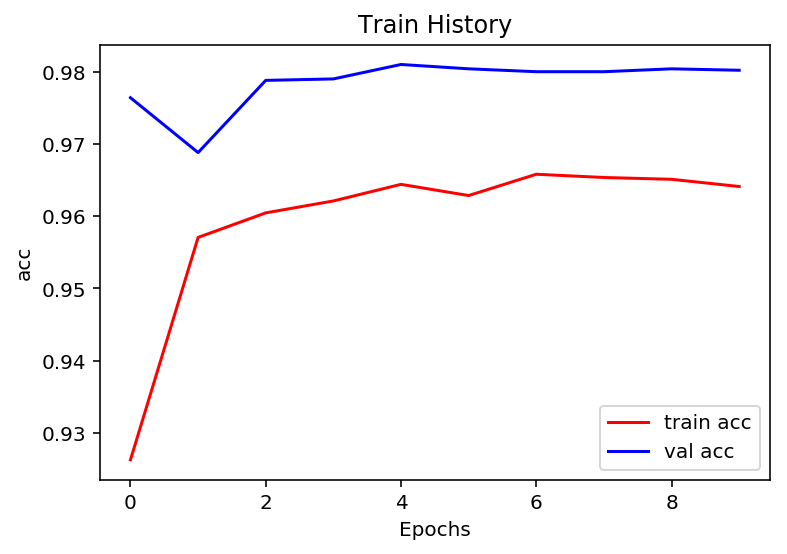

In [28]:
show_train_history(train_history_InceptionV3, "acc", "val_acc")

In [29]:
# 保存模型

# 将模型保存为 JSON
model_json_InceptionV3 = model_InceptionV3.to_json()
with open("model_InceptionV3.json", "w") as json_file:
    json_file.write(model_json_InceptionV3)
# 将权重保存为 HDF5
model_InceptionV3.save_weights("model_InceptionV3.h5")
print("Saved model to Disk")

Saved model to Disk


In [43]:
# 加载预测图像
X_test_299 = np.zeros((12500, 299, 299, 3), dtype=np.uint8)
n = 25000
for i in tqdm(range(int(n/2))):
    X_test_299[i] = cv2.resize(cv2.imread('test1/%d.jpg' %(i+1)), (299, 299))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:53<00:00, 234.11it/s]


In [54]:
# 预测测试集
y_pred_InceptionV3 = model_InceptionV3.predict(X_test_299, verbose=0)
y_pred_InceptionV3= y_pred_InceptionV3.clip(min=0.005, max=0.995)

In [55]:
y_pred_InceptionV3

array([[0.995     ],
       [0.995     ],
       [0.995     ],
       ...,
       [0.97839475],
       [0.995     ],
       [0.00974961]], dtype=float32)

In [56]:
df_InceptionV3 = pd.read_csv("sample_submission.csv")

testImageName =glob.iglob('test1/*.jpg') 

for i in range(12500):
    fname = "train1"+str(i)+".jpg"
#     value = None
#     if  y_pred_InceptionV3[i] > 0.5:
#         value = 1
#     else:
#         value = 0
    value = y_pred_InceptionV3[i]
    df_InceptionV3.set_value(i, 'label',value)

df_InceptionV3.to_csv('y_pred_InceptionV3.csv', index=None)
df_InceptionV3.head(10)

d:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


id     label
0   1  0.995000
1   2  0.995000
2   3  0.995000
3   4  0.993998
4   5  0.005000
5   6  0.005000
6   7  0.005000
7   8  0.005000
8   9  0.005000
9  10  0.005000

Kaggle评分

<img src="img/y_pred_InceptionV3.png" width=900px>

# 三、Fine Tune

In [13]:
# -*- coding:utf-8 -*- 
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger,  History, ModelCheckpoint, EarlyStopping

In [14]:
from keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess_input
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

x = Input((224, 224, 3))
in_tensor = Lambda(resnet_preprocess_input)(x)
y = base_model(in_tensor)

y = GlobalAveragePooling2D()(y)
y = Dropout(0.20)(y)
y = Dense(1, activation='sigmoid')(y)
model_ResNet50_finetuen = Model(x, y)

In [15]:
if 'img_224' not in locals().keys():
    import numpy as np
    from tqdm import tqdm
    import cv2

    np.random.seed(42)

    class Pictures(object):
        def __init__(self,n=25000):
            """构造函数
            # Arguments
                n: 图像数量
            # Return
                None
            """
            self.pic_num = n
            self.shape = None
            self.X = None
            self.y = None

        def resize(self, shape=(224,224)):
            """图像归一化

                img = Pictures()
                img.resize()
            # Arguments
                shape: 规划化后图像尺寸
            # Return
                None
            """
            self.shape = shape
            self.X = np.zeros((self.pic_num, self.shape[0], self.shape[1], 3), dtype=np.uint8)
            self.y = np.zeros((self.pic_num, 1), dtype=np.uint8)
            for i in tqdm(range(int(self.pic_num/2))):
                self.X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg' %i), (self.shape[0], self.shape[1]))
                self.X[i+int(self.pic_num/2)] = cv2.resize(cv2.imread('train/dog.%d.jpg' %i), (self.shape[0], self.shape[1]))

            self.y[int(self.pic_num/2):] = 1
   
    img_224 = Pictures()
    img_224.resize(shape=(224,224))
    from sklearn.model_selection import train_test_split
    X_train_224, X_valid_224, y_train_224, y_valid_224 = train_test_split(img_224.X, img_224.y, test_size=0.2)

In [16]:
model_ResNet50_finetuen.compile(optimizer='adadelta',
                                loss='binary_crossentropy',
                                metrics=['accuracy'])
early_stop_ResNet50 = EarlyStopping(monitor='val_loss', patience=5)
train_history_finetune_ResNet50 = model_ResNet50_finetuen.fit(X_train_224, y_train_224, batch_size=32, epochs=5, verbose=2, 
                                                              validation_data=(X_valid_224, y_valid_224), callbacks=[early_stop_ResNet50])

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
 - 354s - loss: 0.0721 - acc: 0.9736 - val_loss: 0.0658 - val_acc: 0.9798
Epoch 2/5
 - 218s - loss: 0.0202 - acc: 0.9928 - val_loss: 0.0594 - val_acc: 0.9828
Epoch 3/5
 - 217s - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0484 - val_acc: 0.9860
Epoch 4/5
 - 217s - loss: 0.0083 - acc: 0.9975 - val_loss: 0.0686 - val_acc: 0.9836
Epoch 5/5
 - 217s - loss: 0.0050 - acc: 0.9985 - val_loss: 0.0816 - val_acc: 0.9832


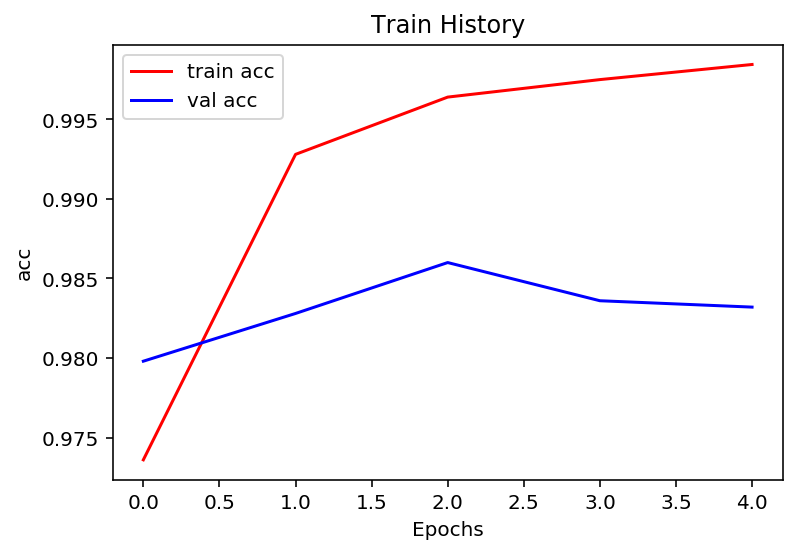

In [17]:
from utils import *
%matplotlib inline
show_train_history(train_history_finetune_ResNet50, "acc", "val_acc")

In [39]:
if 'X_test_224' not in locals().keys():
    X_test_224 = np.zeros((12500, 224, 224, 3), dtype=np.uint8)
    for i in tqdm(range(12500)):
        X_test_224[i] = cv2.resize(cv2.imread('test1/%d.jpg' %(i+1)), (224, 224))

In [18]:
y_pred_finetune_ResNet50 = model_ResNet50_finetuen.predict(X_test_224, verbose=0)
y_pred_finetune_ResNet50 = y_pred_finetune_ResNet50.clip(min=0.005, max=0.995)

In [39]:
import pandas as pd
import glob
df_finetune_ResNet50 = pd.read_csv("sample_submission.csv")

testImageName =glob.iglob('test1/*.jpg') 
bad_image_NO = []
for i in range(12500):
    fname = "train1"+str(i)+".jpg"
#     value = None
#     if  y_pred_finetune_ResNet50[i] > 0.5:
#         value = 1
#     else:
#         value = 0
    if y_pred_finetune_ResNet50[i] > 0.4 and y_pred_finetune_ResNet50[i] < 0.6:
        bad_image_NO.append(i)
#         print(i,y_pred_finetune_ResNet50[i])
    value = y_pred_finetune_ResNet50[i]
    df_finetune_ResNet50.set_value(i, 'label',value)

df_finetune_ResNet50.to_csv('y_pred_finetune_ResNet50.csv', index=None)
df_finetune_ResNet50.head(10)

d:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

Kaggle评分

<img src="img/y_pred_finetune_ResNet50.png" width=900px>

### 显示无法分类的图像

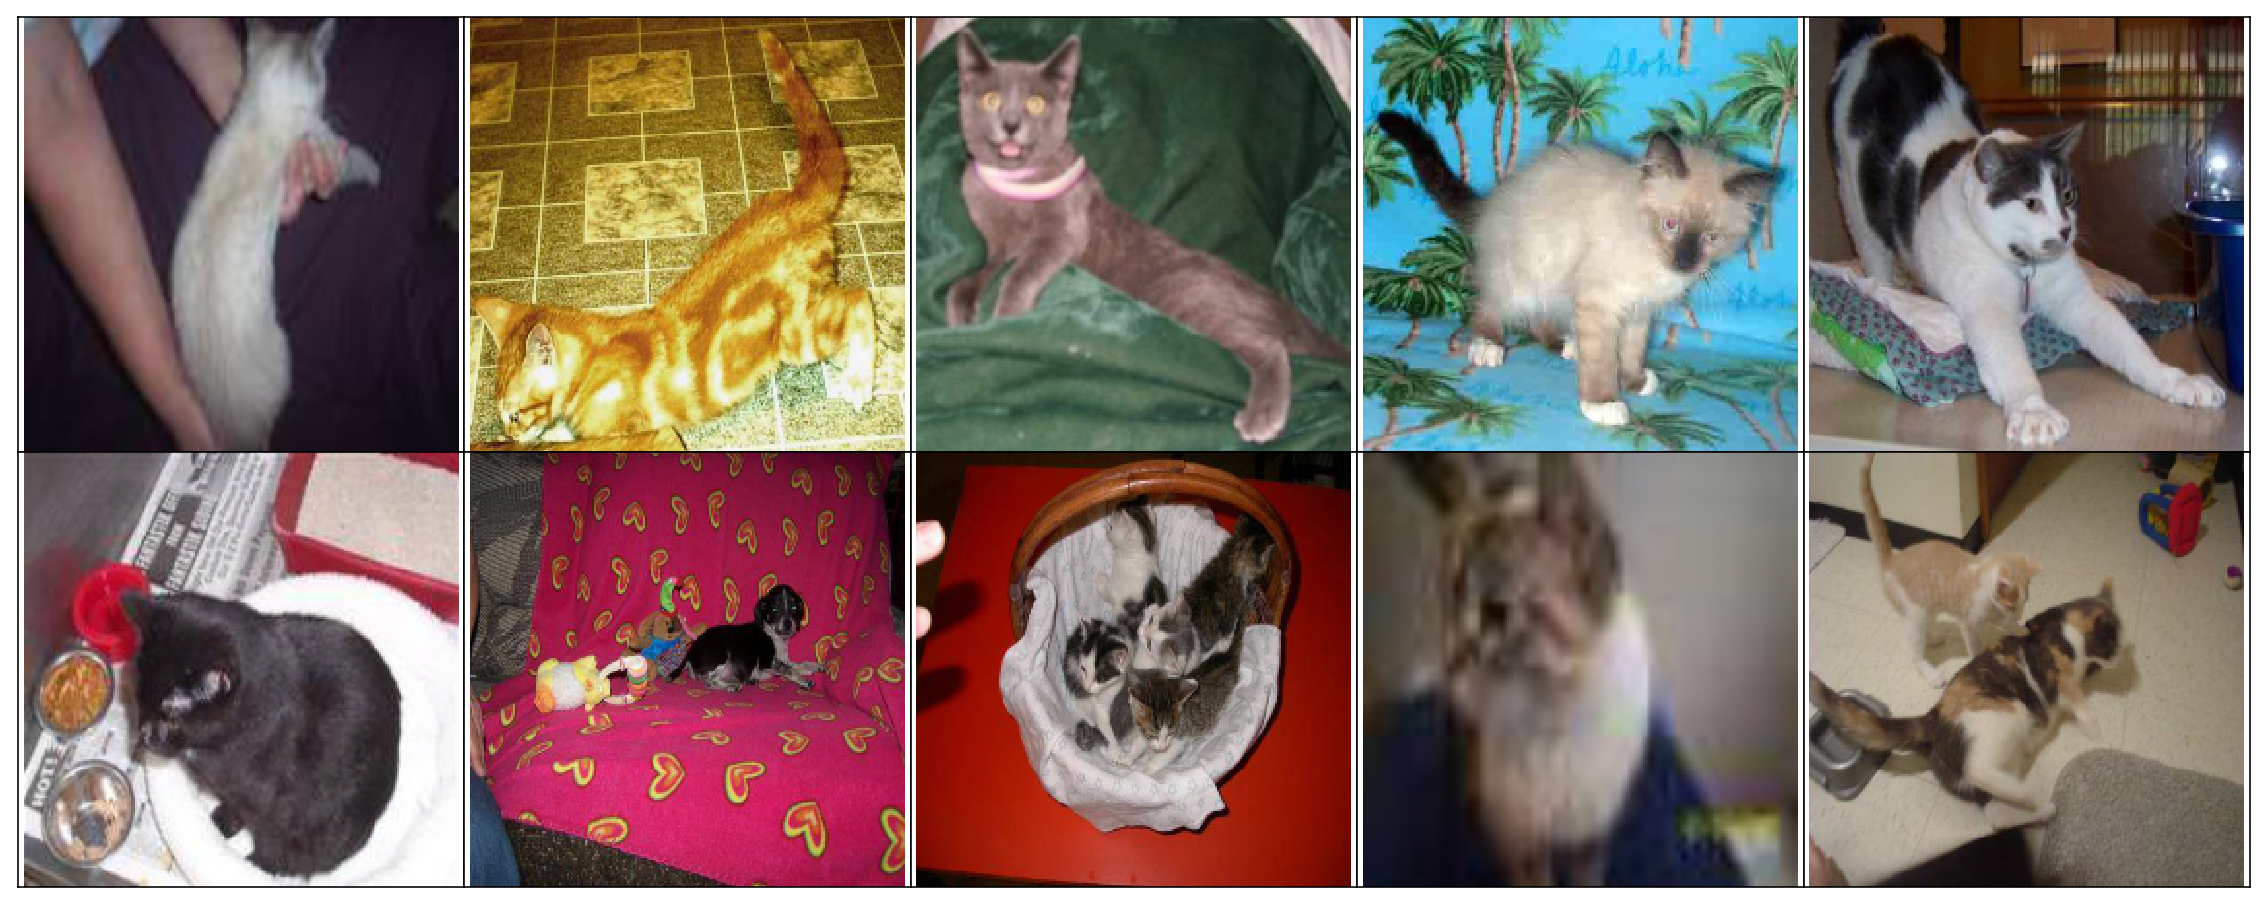

In [42]:
idx =  np.random.choice(bad_image_NO, 10)
fig, axes = plt.subplots(2,5,sharex=True ,sharey=True ,figsize=(20,8))
for i, ax in zip(idx,axes.flatten()):
    ax.imshow(X_test_224[i][:,:,::-1],aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0,hspace=0)

# 四、多模型融合

选择InceptionResNetV2、InceptionV3、Xception这三个模型融合是因为生成的[模型小巧且准确率高](https://towardsdatascience.com/neural-network-architectures-156e5bad51ba)，如下图所示：   

<img src="img/imgNet.png" width=700px>

In [44]:
# -*- coding:utf-8 -*- 
import numpy as np
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.layers.core import *
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger,  History, ModelCheckpoint, EarlyStopping
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inception_resnet2_process
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_v3_process
from keras.applications.xception import Xception, preprocess_input as xception_process

def get_model_features(input_model, preprocess, img_shape, train_data, test_data, train_label=None, batch_size=64):
    inputs = Input(shape=(img_shape[0], img_shape[1], 3))
    in_tensor = Lambda(preprocess)(inputs)
    base_model = input_model(input_tensor=in_tensor, weights='imagenet', include_top=False)
    y = GlobalAveragePooling2D()(base_model.output)
    model = Model(inputs=inputs, outputs=y)
    train_feature = model.predict(train_data, batch_size=batch_size) # 不fit，直接predict
    test_feature = model.predict(test_data, batch_size=batch_size)
    
    with h5py.File("feature_%s.h5" % input_model.__name__, 'w') as f:
        f.create_dataset('train', data=train_feature)
        f.create_dataset('test', data=test_feature)
        f.create_dataset('label', data=train_label)
    return train_feature, test_feature

In [45]:
# 加载299图像
img_299 = Pictures()
img_299.resize(shape=(299,299))

# 加载预测图像
X_test_299 = np.zeros((12500, 299, 299, 3), dtype=np.uint8)
n = 25000
for i in tqdm(range(int(n/2))):
    X_test_299[i] = cv2.resize(cv2.imread('test1/%d.jpg' %(i+1)), (299, 299))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:27<00:00, 143.30it/s]


In [46]:
train_InceptionV3, test_InceptionV3 = get_model_features(InceptionV3, inception_v3_process, (299,299),
                                                         img_299.X, X_test_299,train_label=img_299.y)

In [47]:
train_Xception, test_Xception = get_model_features(Xception, xception_process, (299,299),
                                                   img_299.X, X_test_299, train_label=img_299.y)

In [48]:
train_InceptionResNetV2, test_InceptionResNetV2 = get_model_features(InceptionResNetV2, inception_resnet2_process, (299,299), 
                                                               img_299.X, X_test_299, train_label=img_299.y)

In [49]:
train, test= [], []
for fetch in ['feature_Xception.h5', 'feature_InceptionV3.h5', 'feature_InceptionResNetV2.h5']:
    with h5py.File(fetch, 'r') as h:
        train.append(np.array(h['train']))
        test.append(np.array(h['test']))
        label = np.array(h['label'])

In [50]:
fetch_feature_train = np.concatenate(train, axis=1)
fetch_feature_test = np.concatenate(test, axis=1)

In [51]:
# 划分训练集和验证集
from sklearn.model_selection import train_test_split
X_ft_train, X_ft_valid, y_ft_train, y_ft_valid = train_test_split(fetch_feature_train, img_299.y, test_size=0.2, random_state=42)

In [52]:
inputs = Input(shape=(X_ft_train.shape[1],))

y = Dropout(0.5)(inputs)
y = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(y)
fetch_feature_model = Model(inputs=inputs, outputs=y)
fetch_feature_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

logs_file = 'ft_extract_features-{val_loss:.4f}.h5'
path = os.getcwd()
path_logs = os.path.join(path, logs_file)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_check = ModelCheckpoint(path_logs, monitor='val_loss', save_best_only=True)
    
fetch_feature_model.fit(X_ft_train, y_ft_train, batch_size=32, epochs=5, verbose=2, validation_data=(X_ft_valid, y_ft_valid), 
                        callbacks=[early_stop, model_check])

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
 - 22s - loss: 0.0644 - acc: 0.9850 - val_loss: 0.0242 - val_acc: 0.9922
Epoch 2/5
 - 4s - loss: 0.0197 - acc: 0.9942 - val_loss: 0.0209 - val_acc: 0.9928
Epoch 3/5
 - 4s - loss: 0.0176 - acc: 0.9949 - val_loss: 0.0199 - val_acc: 0.9930
Epoch 4/5
 - 4s - loss: 0.0158 - acc: 0.9951 - val_loss: 0.0195 - val_acc: 0.9932
Epoch 5/5
 - 4s - loss: 0.0158 - acc: 0.9950 - val_loss: 0.0195 - val_acc: 0.9932


In [53]:
import pandas as pd
extract_feature_model = fetch_feature_model.predict(fetch_feature_test)
extract_feature_model = extract_feature_model.clip(min=0.005, max=0.995)
extract_feature_model = extract_feature_model.flatten(order = 'F')
   
submission = pd.DataFrame(data = {'id':(np.arange(len(X_test_299))+1), 'label': extract_feature_model})
submission.to_csv('fetch_extract_feature_submission.csv',index=False)

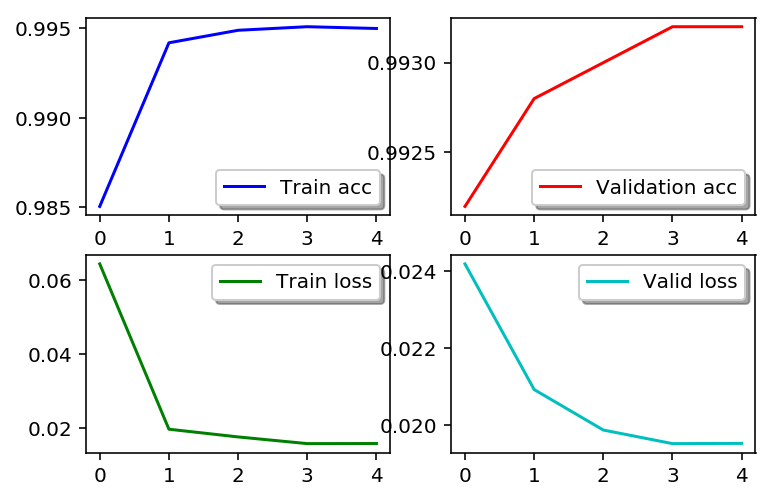

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2)
# fig, ax = plt.subplots(2,1)
ax = ax.flatten()

his_model = fetch_feature_model.history
history = his_model.history


ax[0].plot(history['acc'],color='b',label="Train acc")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history['val_acc'],color='r',label="Validation acc")
legend = ax[1].legend(loc='best', shadow=True)

ax[2].plot(history['loss'],color='g',label="Train loss")
legend = ax[2].legend(loc='best', shadow=True)

ax[3].plot(history['val_loss'],color='c',label="Valid loss")
legend = ax[3].legend(loc='best', shadow=True)

Kaggle评分

<img src="img/fetch_extract_feature_submission.png" width=900px>

### 显示无法分类的图像

In [63]:
bad_image_NO = []
for i in range(len(submission['label'])):
    if submission['label'][i] > 0.4 and submission['label'][i] < 0.6:
        bad_image_NO.append(i)

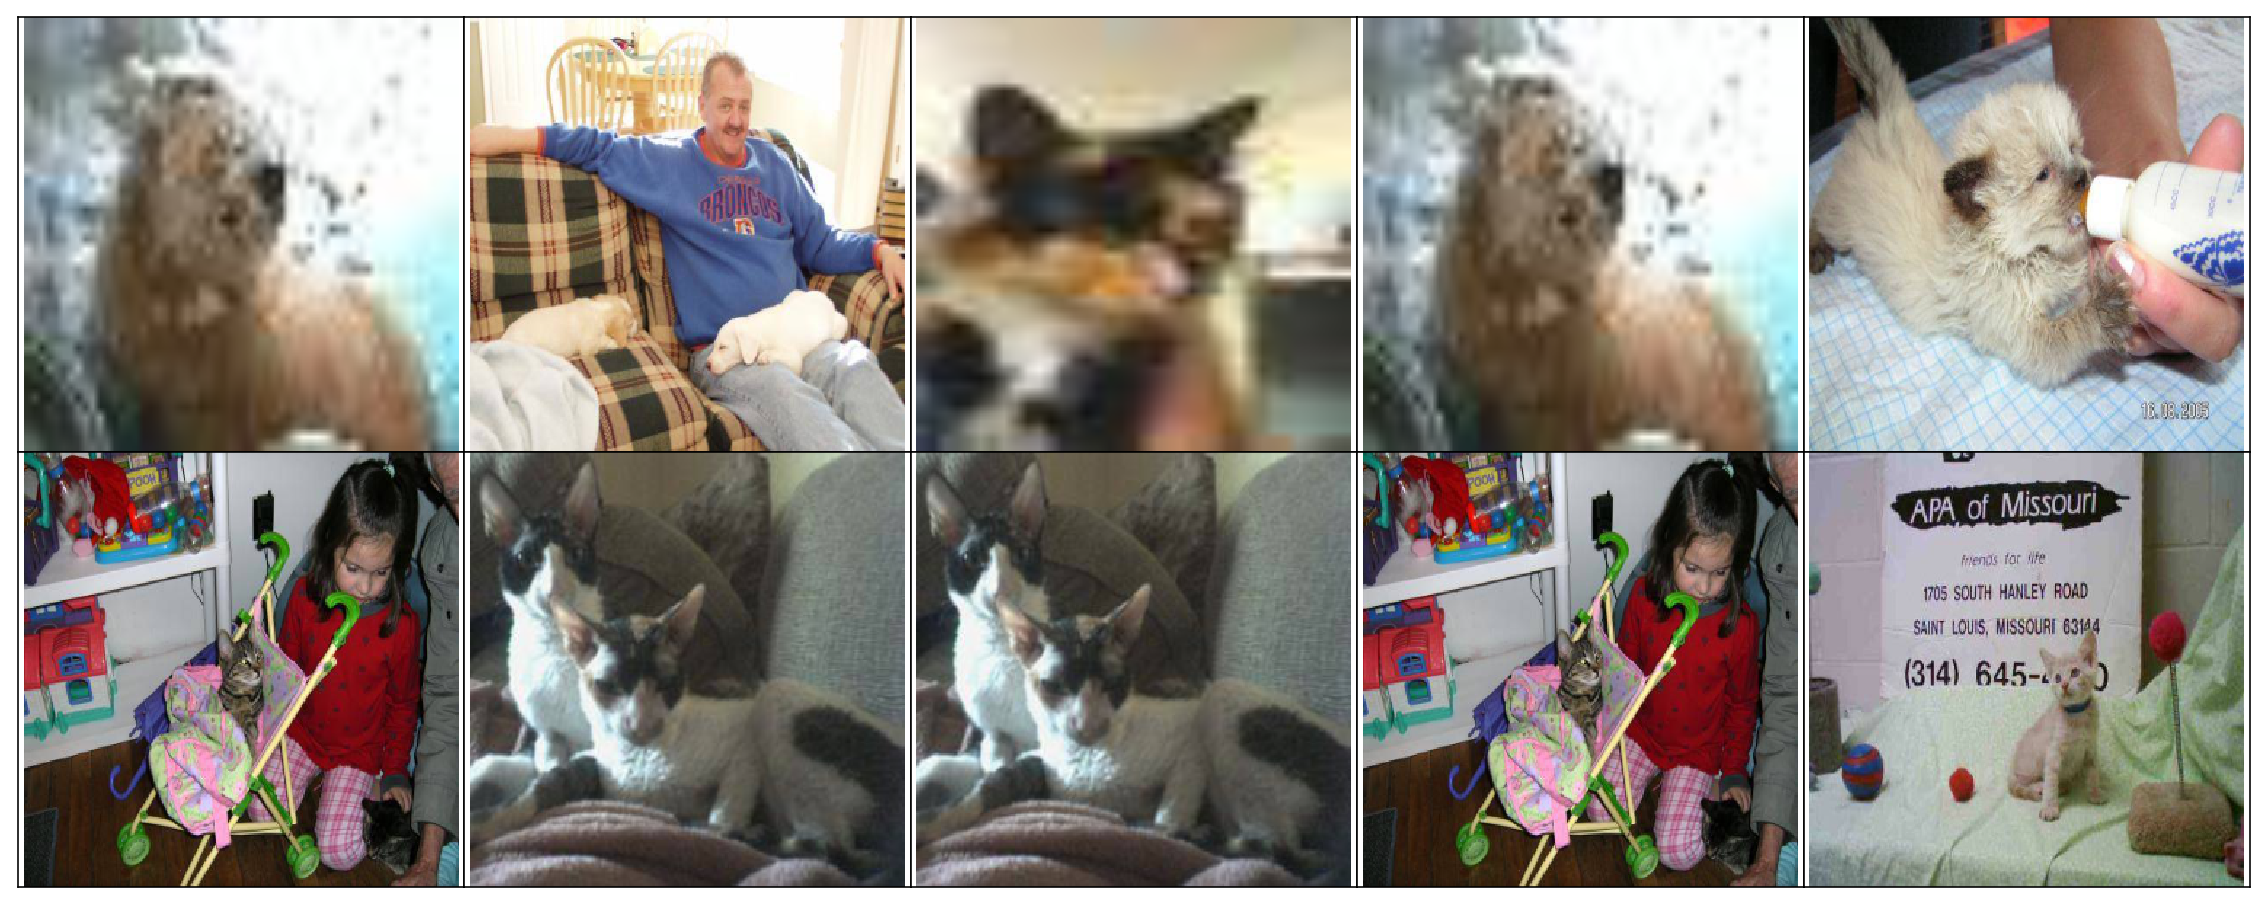

In [70]:
idx =  np.random.choice(bad_image_NO, 10)
fig, axes = plt.subplots(2,5,sharex=True ,sharey=True ,figsize=(20,8))
for i, ax in zip(idx,axes.flatten()):
    ax.imshow(X_test_299[i][:,:,::-1],aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0,hspace=0)